# Data Exploration
In this notebook, data will be explore to get a better understanding of the data, and to make vizualizations for the report.

In [3]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [12]:
#Load the ratings file
ratings = pd.read_csv('../data/title.ratings.tsv', sep='\t')
titles = pd.read_csv('../data/title.basics.tsv', sep='\t')

In [13]:
# Only keep ratings with tconst as movie
ratings =ratings.merge(titles[titles['titleType'] == 'movie'], on='tconst', how='inner')

## Vote binning
Create vote segments using log-based bins for better distribution

These bins are also used for the model evaluation.

In [14]:
# Define vote bins based on log scale and percentiles
# This creates more balanced segments for model evaluation
vote_bins = [
    (0, 10, "Very Low (≤10)"),
    (10, 25, "Low (11-25)"),
    (25, 50, "Low-Medium (26-50)"),
    (50, 100, "Medium (51-100)"),
    (100, 250, "Medium-High (101-250)"),
    (250, 500, "High (251-500)"),
    (500, 1000, "High (501-1K)"),
    (1000, 2500, "Very High (1K-2.5K)"),
    (2500, 5000, "Very High (2.5K-5K)"),
    (5000, 10000, "Popular (5K-10K)"),
    (10000, 25000, "Popular (10K-25K)"),
    (25000, 50000, "Very Popular (25K-50K)"),
    (50000, 100000, "Very Popular (50K-100K)"),
    (100000, float('inf'), "Blockbuster (100K+)")
]

# Create segment labels
def assign_vote_segment(num_votes):
    """Assign a vote segment label based on number of votes"""
    for min_votes, max_votes, label in vote_bins:
        if min_votes <= num_votes < max_votes:
            return label
    return "Blockbuster (100K+)"  # fallback

ratings['vote_segment'] = ratings['numVotes'].apply(assign_vote_segment)

# Display segment distribution
print("Vote Segment Distribution:\n")
# Print segment counts in the order of vote_bins (not alphabetical)
segment_counts = ratings['vote_segment'].value_counts()
for _, _, label in vote_bins:
    count = segment_counts.get(label, 0)
    pct = (count / len(ratings)) * 100
    print(f"{label:30s}: {count:8,} movies ({pct:5.2f}%)")
print(f"\nTotal: {len(ratings):,} movies")


Vote Segment Distribution:

Very Low (≤10)                :   25,401 movies ( 7.52%)
Low (11-25)                   :   77,502 movies (22.93%)
Low-Medium (26-50)            :   51,303 movies (15.18%)
Medium (51-100)               :   42,754 movies (12.65%)
Medium-High (101-250)         :   46,288 movies (13.69%)
High (251-500)                :   27,117 movies ( 8.02%)
High (501-1K)                 :   20,691 movies ( 6.12%)
Very High (1K-2.5K)           :   19,193 movies ( 5.68%)
Very High (2.5K-5K)           :    9,468 movies ( 2.80%)
Popular (5K-10K)              :    6,187 movies ( 1.83%)
Popular (10K-25K)             :    5,100 movies ( 1.51%)
Very Popular (25K-50K)        :    2,523 movies ( 0.75%)
Very Popular (50K-100K)       :    1,838 movies ( 0.54%)
Blockbuster (100K+)           :    2,636 movies ( 0.78%)

Total: 338,001 movies


## Percentage of votes
In this section, the percentage of votes will be calculated to see how many movies have more than 150 votes, and how many have fewer than 40 votes.

In [18]:
# Alternative: Create simplified segments using quantiles for easier analysis
# This creates 5 balanced segments based on percentiles

quantile_bins = [
    (0, ratings['numVotes'].quantile(0.20), "Bottom 20%"),
    (ratings['numVotes'].quantile(0.20), ratings['numVotes'].quantile(0.40), "20-40%"),
    (ratings['numVotes'].quantile(0.40), ratings['numVotes'].quantile(0.60), "40-60%"),
    (ratings['numVotes'].quantile(0.60), ratings['numVotes'].quantile(0.80), "60-80%"),
    (ratings['numVotes'].quantile(0.80), float('inf'), "Top 20%")
]

def assign_quantile_segment(num_votes):
    """Assign a quantile-based segment"""
    for min_votes, max_votes, label in quantile_bins:
        if min_votes <= num_votes < max_votes:
            return label
    return "Top 20%"

ratings['vote_quantile_segment'] = ratings['numVotes'].apply(assign_quantile_segment)

print("Quantile-Based Segments (5 balanced groups):\n")
quantile_counts = ratings['vote_quantile_segment'].value_counts()
for segment, count in quantile_counts.items():
    pct = (count / len(ratings)) * 100
    min_votes = ratings[ratings['vote_quantile_segment'] == segment]['numVotes'].min()
    max_votes = ratings[ratings['vote_quantile_segment'] == segment]['numVotes'].max()
    median_votes = ratings[ratings['vote_quantile_segment'] == segment]['numVotes'].median()
    print(f"{segment:15s}: {count:8,} movies ({pct:5.2f}%) | "
          f"Range: {min_votes:,.0f} - {max_votes:,.0f} | Median: {median_votes:,.0f}")


Quantile-Based Segments (5 balanced groups):

40-60%         :   69,245 movies (20.49%) | Range: 37 - 110 | Median: 61
20-40%         :   68,610 movies (20.30%) | Range: 16 - 36 | Median: 23
60-80%         :   67,837 movies (20.07%) | Range: 111 - 499 | Median: 214
Top 20%        :   67,636 movies (20.01%) | Range: 500 - 3,115,259 | Median: 1,791
Bottom 20%     :   64,673 movies (19.13%) | Range: 5 - 15 | Median: 10


In [19]:
# Calculate exact percentages for the claim
# Claim: ~20% have more than 150 reviews, ~60% receive fewer than 40 reviews

pct_less_than_100 = (ratings['numVotes'] < 100).sum() / len(ratings) * 100
pct_more_than_500 = (ratings['numVotes'] > 500).sum() / len(ratings) * 100
print(f"Movies with fewer than 100 reviews: {pct_less_than_100:.2f}%")
print(f"Movies with more than 500 reviews: {pct_more_than_500:.2f}%")
print()
print(f"Total movies: {len(ratings):,}")
print(f"Movies with < 100 reviews: {(ratings['numVotes'] < 40).sum():,}")
print(f"Movies with > 500 reviews: {(ratings['numVotes'] > 150).sum():,}")

Movies with fewer than 100 reviews: 58.27%
Movies with more than 500 reviews: 20.00%

Total movies: 338,001
Movies with < 100 reviews: 138,852
Movies with > 500 reviews: 118,733


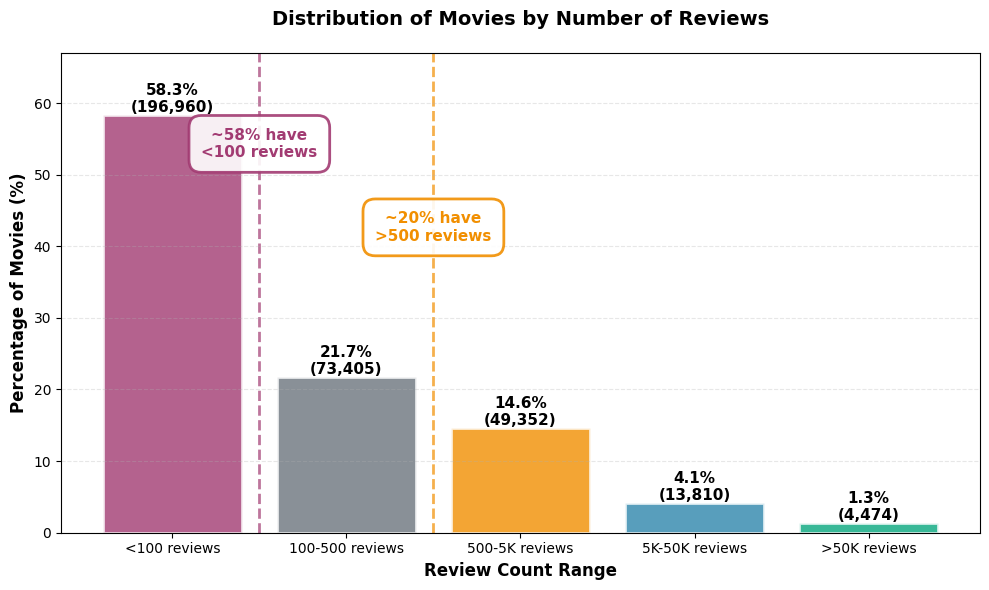

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))

# Create bins that highlight the key thresholds
bins = [0, 100, 500, 5000, 50000, float('inf')]
bin_labels = ['<100 reviews', '100-500 reviews', '500-5K reviews', '5K-50K reviews', '>50K reviews']
colors = ['#A23B72', '#6C757D', '#F18F01', '#2E86AB', '#06A77D']

# Calculate percentages for each bin
bin_counts = []
bin_percentages = []
for i in range(len(bins)-1):
    if bins[i+1] == float('inf'):  # Last bin (open-ended)
        count = (ratings['numVotes'] >= bins[i]).sum()
    else:
        count = ((ratings['numVotes'] >= bins[i]) & (ratings['numVotes'] < bins[i+1])).sum()
    pct = (count / len(ratings)) * 100
    bin_counts.append(count)
    bin_percentages.append(pct)

# Create bar chart
bars = ax.bar(bin_labels, bin_percentages, color=colors, edgecolor='white', linewidth=2, alpha=0.8)

# Add percentage labels on bars
for i, (bar, pct, count) in enumerate(zip(bars, bin_percentages, bin_counts)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{pct:.1f}%\n({count:,})',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Highlight the key thresholds with annotations
ax.axvline(x=0.5, color='#A23B72', linestyle='--', linewidth=2, alpha=0.7, zorder=0)
ax.axvline(x=1.5, color='#F18F01', linestyle='--', linewidth=2, alpha=0.7, zorder=0)

# Add text annotations for key statistics
ax.text(0.5, max(bin_percentages) * 0.9, f'~{pct_less_than_100:.0f}% have\n<100 reviews', 
        ha='center', fontsize=11, fontweight='bold', color='#A23B72',
        bbox=dict(boxstyle='round,pad=0.8', facecolor='white', edgecolor='#A23B72', linewidth=2, alpha=0.9))
ax.text(1.5, max(bin_percentages) * 0.7, f'~{pct_more_than_500:.0f}% have\n>500 reviews', 
        ha='center', fontsize=11, fontweight='bold', color='#F18F01',
        bbox=dict(boxstyle='round,pad=0.8', facecolor='white', edgecolor='#F18F01', linewidth=2, alpha=0.9))

ax.set_ylabel('Percentage of Movies (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Review Count Range', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Movies by Number of Reviews', fontsize=14, fontweight='bold', pad=20)
ax.set_ylim(0, max(bin_percentages) * 1.15)
ax.grid(True, alpha=0.3, linestyle='--', axis='y')
ax.tick_params(labelsize=10)

plt.tight_layout()
#plt.savefig('../vote_distribution_simple_appendix.png', dpi=300, bbox_inches='tight')
plt.show()

#print(f"\nSimplified visualization saved as 'vote_distribution_simple_appendix.png'")


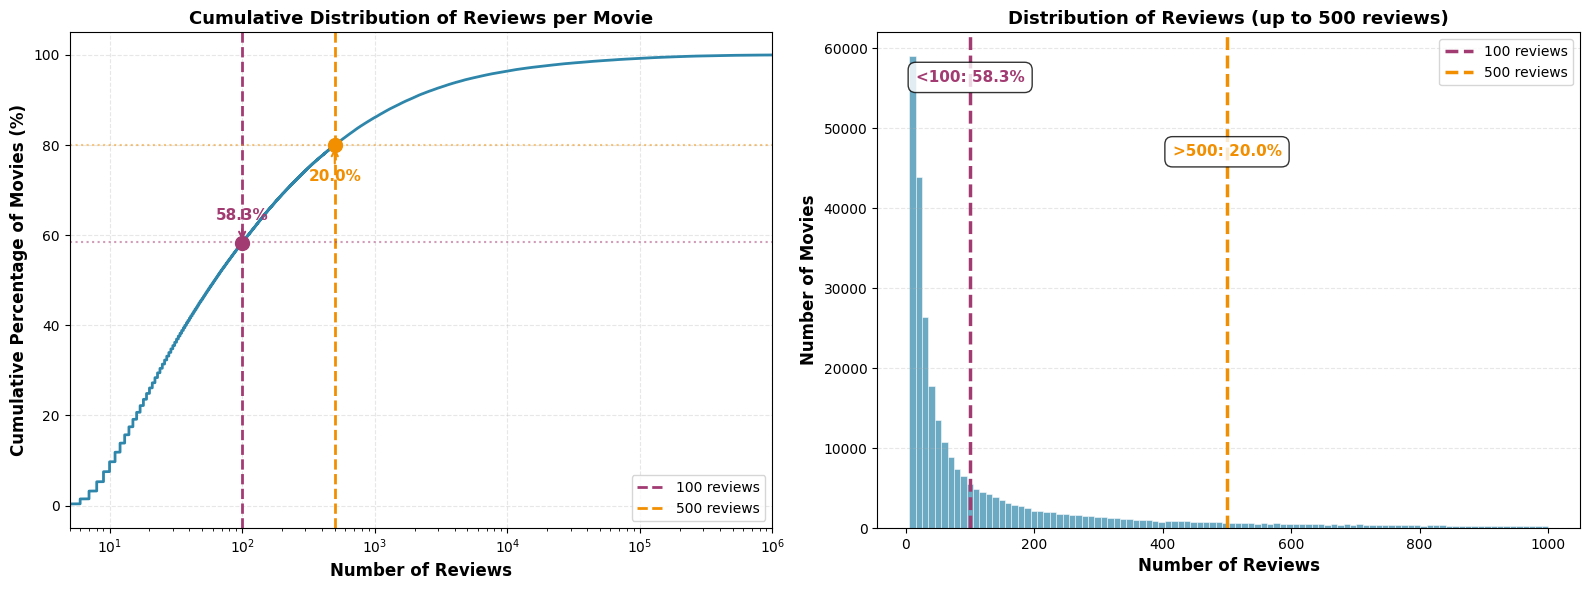


Visualization saved as 'vote_distribution_appendix.png'

Key Statistics:
  • 58.3% of movies have fewer than 100 reviews
  • 20.0% of movies have more than 500 reviews


In [30]:
# Create publication-ready visualization for appendix
# Shows the distribution of reviews and highlights the key thresholds

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Cumulative Distribution Function
sorted_votes = np.sort(ratings['numVotes'].values)
percentiles = np.arange(1, len(sorted_votes) + 1) / len(sorted_votes) * 100

axes[0].plot(sorted_votes, percentiles, linewidth=2, color='#2E86AB')
axes[0].axvline(x=100, color='#A23B72', linestyle='--', linewidth=2, label='100 reviews')
axes[0].axvline(x=500, color='#F18F01', linestyle='--', linewidth=2, label='500 reviews')
axes[0].axhline(y=58.5, color='#A23B72', linestyle=':', alpha=0.5)
axes[0].axhline(y=80, color='#F18F01', linestyle=':', alpha=0.5)

# Find and annotate the exact points
idx_100 = np.searchsorted(sorted_votes, 100)
pct_at_100 = (idx_100 / len(sorted_votes)) * 100
idx_500 = np.searchsorted(sorted_votes, 500)
pct_at_500 = (idx_500 / len(sorted_votes)) * 100

axes[0].plot(100, pct_at_100, 'o', color='#A23B72', markersize=10, zorder=5)
axes[0].plot(500, pct_at_500, 'o', color='#F18F01', markersize=10, zorder=5)
axes[0].annotate(f'{pct_at_100:.1f}%', xy=(100, pct_at_100), 
                xytext=(100, pct_at_100 + 5), fontsize=11, fontweight='bold',
                ha='center', color='#A23B72',
                arrowprops=dict(arrowstyle='->', color='#A23B72', lw=1.5))
axes[0].annotate(f'{100-pct_at_500:.1f}%', xy=(500, pct_at_500), 
                xytext=(500, pct_at_500 - 8), fontsize=11, fontweight='bold',
                ha='center', color='#F18F01',
                arrowprops=dict(arrowstyle='->', color='#F18F01', lw=1.5))

axes[0].set_xlabel('Number of Reviews', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Cumulative Percentage of Movies (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Cumulative Distribution of Reviews per Movie', fontsize=13, fontweight='bold')
axes[0].set_xscale('log')
axes[0].set_xlim(5, 1000000)
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].legend(fontsize=10, loc='lower right')
axes[0].tick_params(labelsize=10)

# Right plot: Histogram with key thresholds highlighted
# Focus on the range up to 1000 votes for better visibility
votes_subset = ratings[ratings['numVotes'] <= 1000]['numVotes']
axes[1].hist(votes_subset, bins=100, color='#2E86AB', edgecolor='white', linewidth=0.5, alpha=0.7)
axes[1].axvline(x=100, color='#A23B72', linestyle='--', linewidth=2.5, label='100 reviews')
axes[1].axvline(x=500, color='#F18F01', linestyle='--', linewidth=2.5, label='500 reviews')

# Add text annotations (The bubbles)
axes[1].text(100, axes[1].get_ylim()[1] * 0.9, f'<100: {pct_less_than_100:.1f}%', 
            fontsize=11, fontweight='bold', color='#A23B72',
            ha='center', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))
axes[1].text(500, axes[1].get_ylim()[1] * 0.75, f'>500: {pct_more_than_500:.1f}%', 
            fontsize=11, fontweight='bold', color='#F18F01',
            ha='center', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

axes[1].set_xlabel('Number of Reviews', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Movies', fontsize=12, fontweight='bold')
axes[1].set_title('Distribution of Reviews (up to 500 reviews)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, linestyle='--', axis='y')
axes[1].legend(fontsize=10, loc='upper right')
axes[1].tick_params(labelsize=10)

plt.tight_layout()
#plt.savefig('../vote_distribution_appendix.png', dpi=300, bbox_inches='tight')
plt.show()

#print(f"\nVisualization saved as 'vote_distribution_appendix.png'")
print(f"\nKey Statistics:")
print(f"  • {pct_less_than_100:.1f}% of movies have fewer than 100 reviews")
print(f"  • {pct_more_than_500:.1f}% of movies have more than 500 reviews")


# Mean
In this section the mean of the movie scores in the training set will be calculated, and inserted as the predicted y-values for the test set.

In [ ]:
train_set_path = os.path.join('..', 'data', 'training_dataset.csv')
df_train = pd.read_csv(train_set_path, sep=';')

test_set_path = os.path.join('..', 'data', 'test_dataset.csv')
df_test = pd.read_csv(test_set_path, sep=';')

y_true = np.expm1(df_test['movie_score'].values)

# Calculate the mean of the movie scores in the training set
mean_movie_score = np.expm1(df_train['movie_score']).mean()
df_test['predicted_movie_score'] = mean_movie_score
y_pred = df_test['predicted_movie_score'].values

In [11]:
mean_movie_score

np.float64(4156.512643143867)

In [10]:
# Calculate R2, MAE and RMSE
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Calculate R2
r2 = r2_score(y_true, y_pred)

# Calculate MAE
mae = mean_absolute_error(y_true, y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Print the results
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

R2: -0.0040
MAE: 5720.1258
RMSE: 23426.1712
